<a href="https://colab.research.google.com/github/abotg/Alex-Botgros-Projects-/blob/main/StatArb_Pairs_Trading_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [ ]:
tickers = ['KO', 'PEP']
start_date = '2018-01-01'
end_date = '2023-12-31'

# Step 3: Download data (with adjusted 'Close' prices — default since auto_adjust=True)
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Step 4: Extract the 'Close' level (these are adjusted if auto_adjust=True)
adj_close = raw_data.xs('Close', axis=1, level=0)

# Step 5: Drop missing values
adj_close = adj_close.dropna()

# Step 6: Preview the data
adj_close.head()

NameError: name 'yf' is not defined

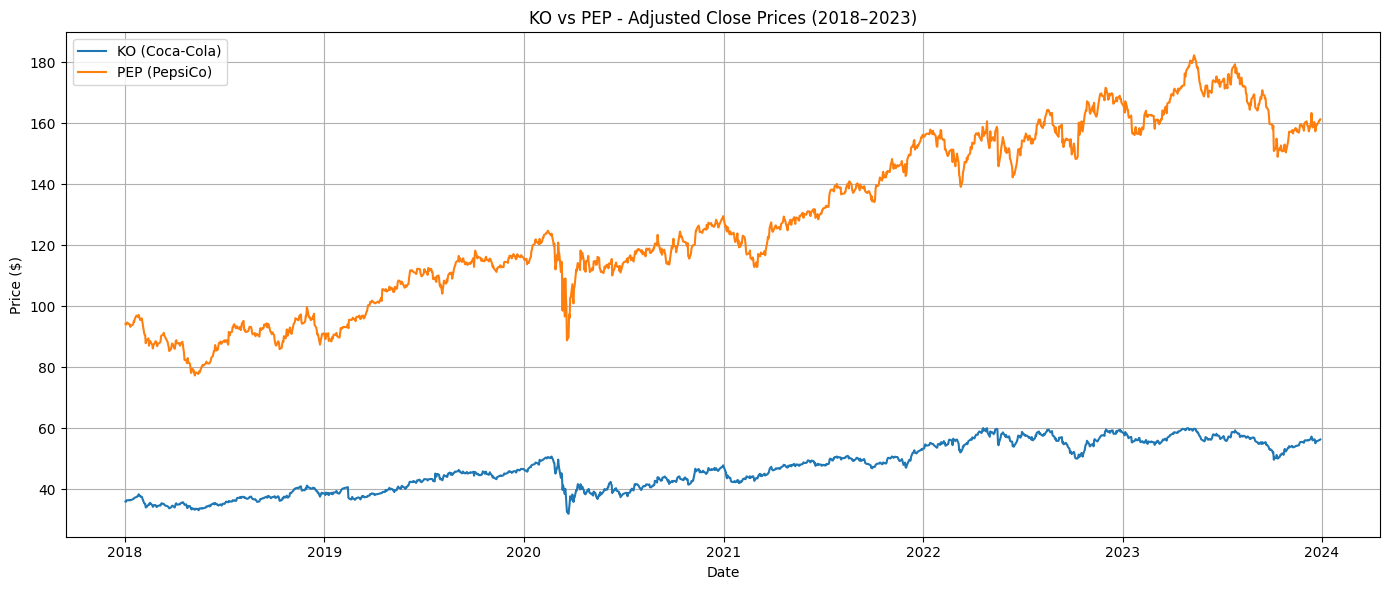

In [ ]:
# Plot KO and PEP adjusted close prices
plt.figure(figsize=(14, 6))
plt.plot(adj_close.index, adj_close['KO'], label='KO (Coca-Cola)')
plt.plot(adj_close.index, adj_close['PEP'], label='PEP (PepsiCo)')
plt.title('KO vs PEP - Adjusted Close Prices (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Step 1: Choose stock A and B
stock_A = adj_close['KO']
stock_B = adj_close['PEP']

# Step 2: Run Engle-Granger cointegration test
coint_t, p_value, crit_value = coint(stock_A, stock_B)

# Step 3: Print result
print("Engle-Granger Cointegration Test:")
print(f"Test statistic: {coint_t:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical values: {crit_value}")

Engle-Granger Cointegration Test:
Test statistic: -3.4070
P-value: 0.0416
Critical values: [-3.90371728 -3.34018479 -3.04726366]


Hedge Ratio (Beta): 0.2718


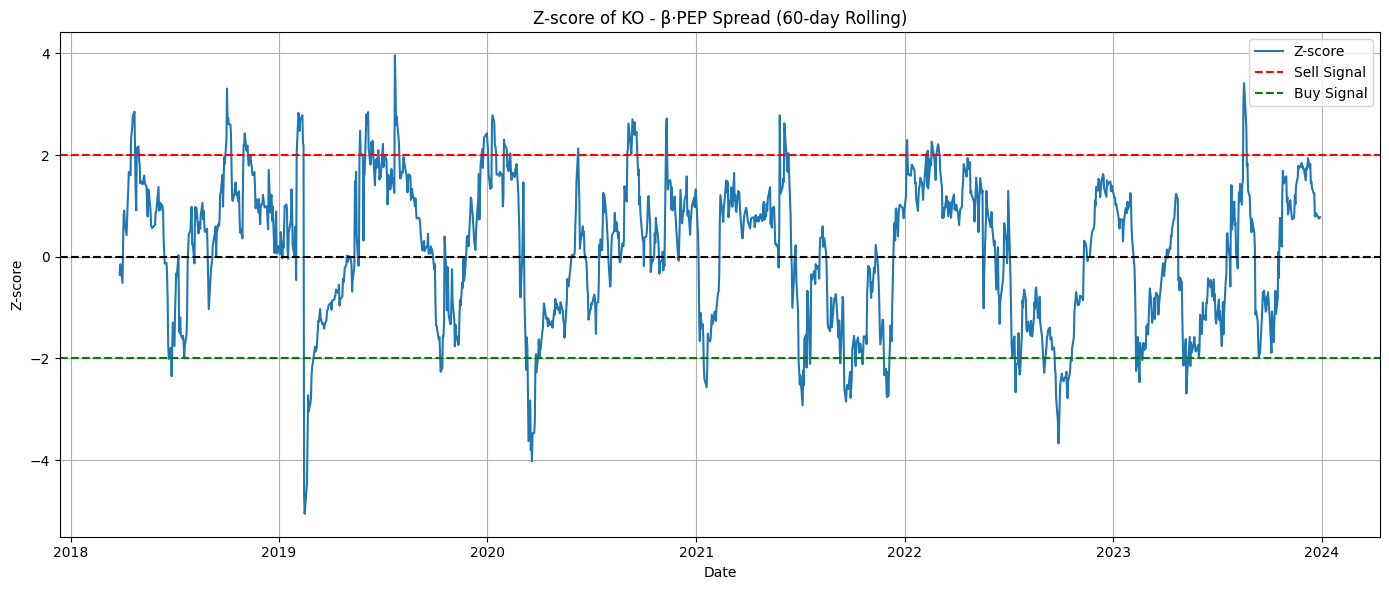

In [ ]:
# 1. Regress KO on PEP to get hedge ratio (beta)
X = sm.add_constant(adj_close['PEP'])  # Add intercept
model = sm.OLS(adj_close['KO'], X).fit()
beta = model.params['PEP']
print(f"Hedge Ratio (Beta): {beta:.4f}")

# 2. Compute the spread
spread = adj_close['KO'] - beta * adj_close['PEP']

# 3. Compute rolling mean and std of the spread
window = 60  # 60-day rolling window
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# 4. Compute Z-score of the spread
zscore = (spread - rolling_mean) / rolling_std

# 5. Plot the Z-score
plt.figure(figsize=(14,6))
plt.plot(zscore, label='Z-score')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--', label='Sell Signal')
plt.axhline(-2, color='green', linestyle='--', label='Buy Signal')
plt.title('Z-score of KO - β·PEP Spread (60-day Rolling)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Initialize positions
position_ko = np.zeros(len(zscore))
position_pep = np.zeros(len(zscore))

# Track state
current_position = 0  # 0 = flat, 1 = long spread, -1 = short spread
stop_loss_threshold = 3.5

# Loop with logic
for t in range(window, len(zscore)):
    z = zscore.iloc[t]

    # Entry conditions
    if current_position == 0:
        if z < -2:
            current_position = 1  # enter long spread
        elif z > 2:
            current_position = -1  # enter short spread

    # Exit condition: mean reversion
    elif abs(z) < 0.5:
        current_position = 0  # exit

    # Exit condition: stop-loss
    elif abs(z) > stop_loss_threshold:
        current_position = 0  # exit forcibly due to large divergence

    # Assign positions based on state
    if current_position == 1:
        position_ko[t] = 1
        position_pep[t] = -beta
    elif current_position == -1:
        position_ko[t] = -1
        position_pep[t] = beta
    else:
        position_ko[t] = 0
        position_pep[t] = 0

# Package into DataFrame
signals_with_stop = pd.DataFrame({
    'KO Position': position_ko,
    'PEP Position': position_pep
}, index=adj_close.index)

signals_with_stop.iloc[window:window+10]

print("Long signals (Z < -2):", np.sum(zscore < -2))
print("Short signals (Z > 2):", np.sum(zscore > 2))



Long signals (Z < -2): 102
Short signals (Z > 2): 101


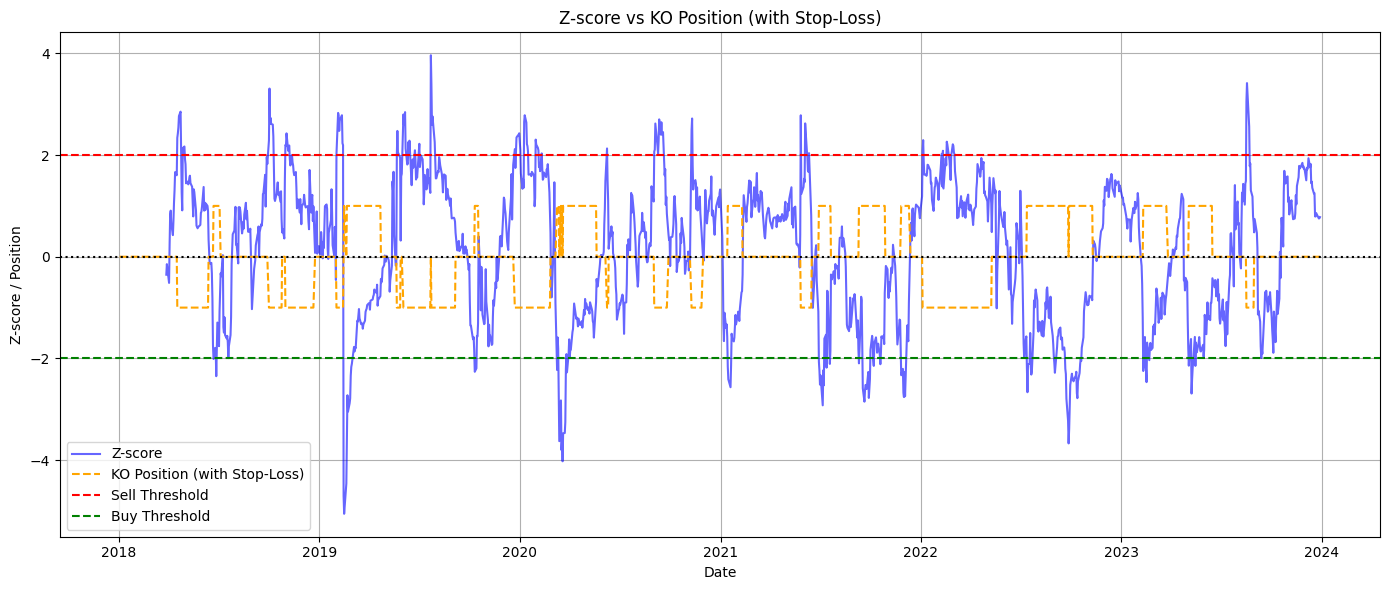

In [ ]:
plt.figure(figsize=(14, 6))

# Plot Z-score
plt.plot(zscore, label='Z-score', color='blue', alpha=0.6)

# Plot KO positions from the stop-loss-enabled signals
plt.plot(signals_with_stop['KO Position'], label='KO Position (with Stop-Loss)', color='orange', linestyle='--')

# Threshold lines
plt.axhline(2, color='red', linestyle='--', label='Sell Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(0, color='black', linestyle=':')

# Decorations
plt.title('Z-score vs KO Position (with Stop-Loss)')
plt.xlabel('Date')
plt.ylabel('Z-score / Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Daily log returns
log_returns = np.log(adj_close / adj_close.shift(1))

# Multiply returns by positions
strategy_returns = (
    signals_with_stop['KO Position'].shift(1) * log_returns['KO'] +
    signals_with_stop['PEP Position'].shift(1) * log_returns['PEP']
)

# Drop NaNs
strategy_returns = strategy_returns.dropna()


In [ ]:
cumulative_returns = strategy_returns.cumsum().apply(np.exp)

total_return = cumulative_returns.iloc[-1] - 1
n_days = len(strategy_returns)
annualized_return = (1 + total_return) ** (252 / n_days) - 1


In [ ]:
# Convert daily to annualized metrics
mean_return = strategy_returns.mean()
std_return = strategy_returns.std()
downside_std = strategy_returns[strategy_returns < 0].std()

trading_days = 252  # Assume 252 trading days/year

sharpe_ratio = (mean_return / std_return) * np.sqrt(trading_days)
sortino_ratio = (mean_return / downside_std) * np.sqrt(trading_days)


In [ ]:
# Cumulative strategy equity
equity_curve = strategy_returns.cumsum().apply(np.exp)

# Running maximum
rolling_max = equity_curve.cummax()

# Drawdown
drawdown = equity_curve / rolling_max - 1.0
max_drawdown = drawdown.min()


In [ ]:
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Percentage Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")

Sharpe Ratio: 0.35
Sortino Ratio: 0.33
Max Drawdown: -20.60%
Total Percentage Return: 29.39%
Annualized Return: 4.40%


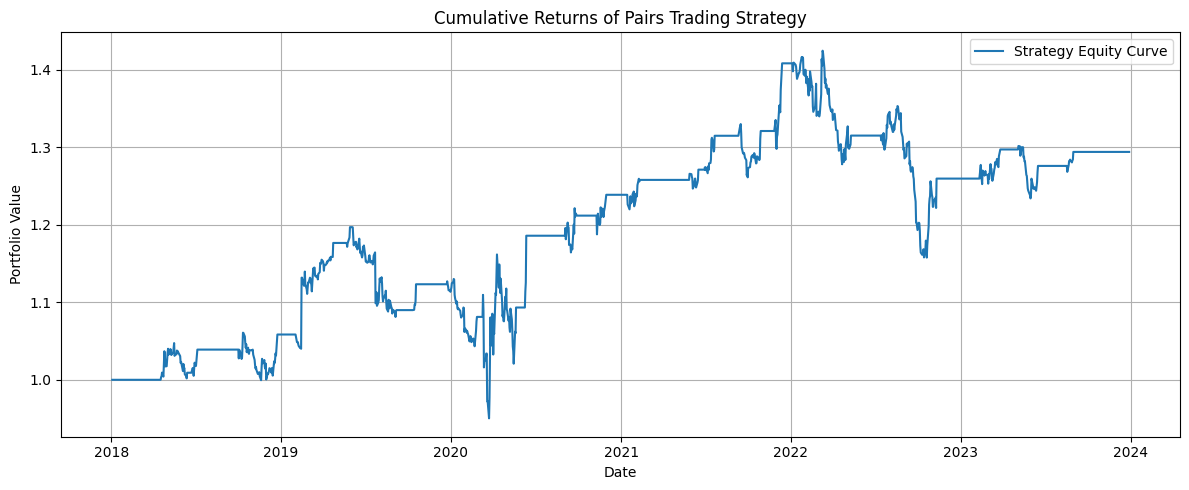

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns, label='Strategy Equity Curve')
plt.title("Cumulative Returns of Pairs Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
transaction_cost = 0.00005
# 1. Daily returns without cost (already done)
log_returns = np.log(adj_close / adj_close.shift(1))

# 2. Shift positions to apply them realistically
ko_position = signals_with_stop['KO Position'].shift(1)
pep_position = signals_with_stop['PEP Position'].shift(1)

# 3. Raw strategy return
strategy_returns = ko_position * log_returns['KO'] + pep_position * log_returns['PEP']

# 4. Calculate position changes (entry/exit triggers cost)
ko_trade_change = signals_with_stop['KO Position'].diff().abs()
pep_trade_change = signals_with_stop['PEP Position'].diff().abs()

# 5. Total daily cost = cost per leg × position change × price level
daily_costs = transaction_cost * (
    ko_trade_change * adj_close['KO'] +
    pep_trade_change * abs(beta) * adj_close['PEP']
)

# Normalize cost to log-return scale (approximate % of portfolio value)
# We'll assume $1 portfolio value for now
cost_return = daily_costs / 1.0

# 6. Adjust returns for cost
strategy_returns_net = strategy_returns - cost_return
strategy_returns_net = strategy_returns_net.dropna()

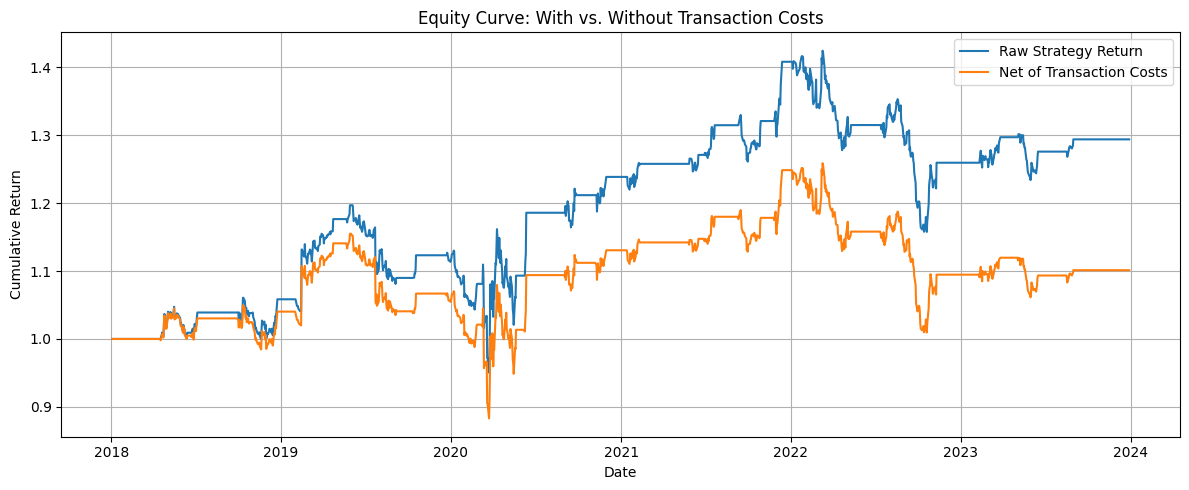

In [ ]:
cumulative_raw = strategy_returns.cumsum().apply(np.exp)
cumulative_net = strategy_returns_net.cumsum().apply(np.exp)

plt.figure(figsize=(12, 5))
plt.plot(cumulative_raw, label='Raw Strategy Return')
plt.plot(cumulative_net, label='Net of Transaction Costs')
plt.title('Equity Curve: With vs. Without Transaction Costs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Capital Allocation Parameters ---
initial_capital = 100000  # Starting portfolio value in USD
capital_per_leg = initial_capital / 2  # Market-neutral assumption

# 1. Shift position signals
ko_signal = signals_with_stop['KO Position'].shift(1)
pep_signal = signals_with_stop['PEP Position'].shift(1)

# 2. Price data and returns
prices = adj_close
daily_returns = prices.pct_change()

# 3. Dollar exposure per asset
ko_dollar_exposure = ko_signal * capital_per_leg
pep_dollar_exposure = pep_signal * capital_per_leg

# 4. Dollar PnL per asset
ko_pnl = ko_dollar_exposure * daily_returns['KO']
pep_pnl = pep_dollar_exposure * daily_returns['PEP']
daily_pnl = ko_pnl + pep_pnl

# 5. Transaction costs (same structure)
ko_trades = signals_with_stop['KO Position'].diff().abs()
pep_trades = signals_with_stop['PEP Position'].diff().abs()
cost_per_trade = 0.0005  # 0.05%

ko_cost = ko_trades * capital_per_leg * cost_per_trade
pep_cost = pep_trades * capital_per_leg * abs(beta) * cost_per_trade
daily_cost = ko_cost + pep_cost

# 6. Net PnL after transaction cost
net_daily_pnl = daily_pnl - daily_cost

# 7. Equity Curve
equity_curve = net_daily_pnl.cumsum() + initial_capital
equity_curve = net_daily_pnl.cumsum() + initial_capital

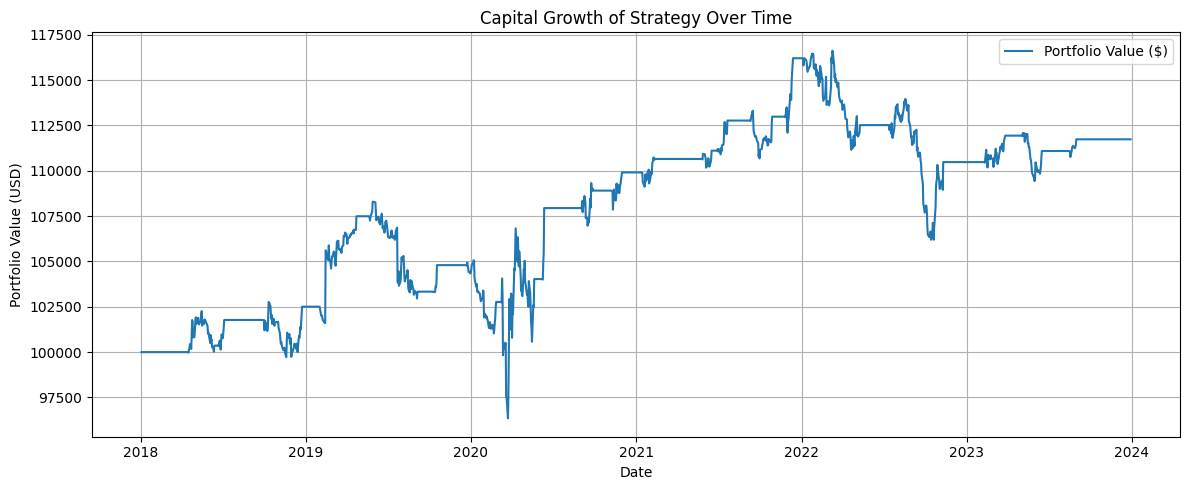

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(equity_curve, label='Portfolio Value ($)')
plt.title('Capital Growth of Strategy Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
spy_raw = yf.download('SPY', start=adj_close.index[0], end=adj_close.index[-1])

# Use only the 'Close' prices (to match how we're handling KO/PEP)
spy_close = spy_raw['Close'].reindex(adj_close.index).dropna()
print(spy_close.head())
print(spy_close.tail())

/tmp/ipython-input-63-864863630.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_raw = yf.download('SPY', start=adj_close.index[0], end=adj_close.index[-1])
[*********************100%***********************]  1 of 1 completed

Ticker             SPY
Date                  
2018-01-02  238.568710
2018-01-03  240.077805
2018-01-04  241.089630
2018-01-05  242.696198
2018-01-08  243.140060
Ticker             SPY
Date                  
2023-12-21  463.942017
2023-12-22  464.874451
2023-12-26  466.837372
2023-12-27  467.681427
2023-12-28  467.858093


In [ ]:
# 1. Daily returns
spy_daily_returns = spy_close.pct_change().dropna()

# 2. Cumulative return
spy_cumulative_return = spy_close.values[-1] / spy_close.values[0] - 1

# 3. Annualized return and volatility
spy_annual_return = spy_daily_returns.mean() * 252
spy_annual_volatility = spy_daily_returns.std() * (252 ** 0.5)

# 4. Sharpe Ratio (Rf = 0)
spy_sharpe = spy_annual_return / spy_annual_volatility

# 5. Sortino Ratio (downside std only)
downside_std = spy_daily_returns[spy_daily_returns < 0].std() * (252 ** 0.5)
spy_sortino = spy_annual_return / downside_std

# 6. Max Drawdown
rolling_max = spy_close.cummax()
drawdown = spy_close / rolling_max - 1
spy_max_drawdown = drawdown.min()
print("SPY Performance Summary:")
print(f"Cumulative Return: {float(spy_cumulative_return):.2%}")
print(f"Annual Return:     {float(spy_annual_return):.2%}")
print(f"Volatility:        {float(spy_annual_volatility):.2%}")
print(f"Sharpe Ratio:      {float(spy_sharpe):.2f}")
print(f"Sortino Ratio:     {float(spy_sortino):.2f}")
print(f"Max Drawdown:      {float(spy_max_drawdown):.2%}")

SPY Performance Summary:
Cumulative Return: 96.11%
Annual Return:     13.35%
Volatility:        20.39%
Sharpe Ratio:      0.65
Sortino Ratio:     0.80
Max Drawdown:      -33.72%


/tmp/ipython-input-69-1753122413.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Cumulative Return: {float(spy_cumulative_return):.2%}")
/tmp/ipython-input-69-1753122413.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Annual Return:     {float(spy_annual_return):.2%}")
/tmp/ipython-input-69-1753122413.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Volatility:        {float(spy_annual_volatility):.2%}")
/tmp/ipython-input-69-1753122413.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inst

In [ ]:
def run_strategy(entry=2.0, exit=0.5, window=60, stop_loss=3.5):
    # 1. Recalculate spread and z-score using rolling window
    spread = adj_close['KO'] - beta * adj_close['PEP']
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    zscore = (spread - spread_mean) / spread_std

    # 2. Initialize position arrays
    position_ko = np.zeros(len(zscore))
    position_pep = np.zeros(len(zscore))
    current_position = 0

    # 3. Signal logic loop
    for t in range(window, len(zscore)):
        z = zscore.iloc[t]

        if current_position == 0:
            if z < -entry:
                current_position = 1
            elif z > entry:
                current_position = -1
        elif abs(z) < exit or abs(z) > stop_loss:
            current_position = 0

        if current_position == 1:
            position_ko[t] = 1
            position_pep[t] = -beta
        elif current_position == -1:
            position_ko[t] = -1
            position_pep[t] = beta

    # 4. Convert to DataFrame
    signals = pd.DataFrame({
        'KO Position': position_ko,
        'PEP Position': position_pep
    }, index=adj_close.index)

    # 5. Calculate log returns
    log_returns = np.log(adj_close / adj_close.shift(1))

    # 6. Align positions (shift to simulate next-day execution)
    ko_position = signals['KO Position'].shift(1)
    pep_position = signals['PEP Position'].shift(1)

    # 7. Strategy return
    strategy_returns = ko_position * log_returns['KO'] + pep_position * log_returns['PEP']
    strategy_returns = strategy_returns.dropna()

    # 8. Metrics
    cumulative_return = strategy_returns.add(1).prod() - 1
    annual_return = strategy_returns.mean() * 252
    annual_volatility = strategy_returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_volatility if annual_volatility != 0 else 0

    downside_std = strategy_returns[strategy_returns < 0].std() * np.sqrt(252)
    sortino = annual_return / downside_std if downside_std != 0 else 0

    return {
        'return': cumulative_return,
        'sharpe': sharpe,
        'sortino': sortino
    }



In [ ]:
entry_thresholds = [1.5, 2.0, 2.5]
exit_thresholds = [0.2, 0.5, 0.8]
window_sizes = [30, 60, 90]

results = []

for entry in entry_thresholds:
    for exit in exit_thresholds:
        for window in window_sizes:
            performance = run_strategy(entry, exit, window)
            results.append({
                'Entry': entry,
                'Exit': exit,
                'Window': window,
                'Sharpe': performance['sharpe'],
                'Return': performance['return']
            })

results_df = pd.DataFrame(results)

In [ ]:
results_df

,Entry,Exit,Window,Sharpe,Return
0,1.5,0.2,30,-0.089251,-0.125379
1,1.5,0.2,60,0.487772,0.425760
2,1.5,0.2,90,0.365496,0.271902
3,1.5,0.5,30,0.186632,0.100620
4,1.5,0.5,60,0.419523,0.325033
5,1.5,0.5,90,0.140307,0.060623
6,1.5,0.8,30,0.254325,0.156093
7,1.5,0.8,60,0.632593,0.542464
8,1.5,0.8,90,0.209058,0.116161
9,2.0,0.2,30,0.154690,0.072541


In [ ]:

pairs = [
    ('KO', 'PEP'),
    ('MSFT', 'AAPL'),
    ('JPM', 'BAC')]

In [ ]:
# Define your stock pairs
pairs = [
    ('KO', 'PEP'),
    ('MSFT', 'AAPL'),
    ('JPM', 'BAC')
]

# Flatten and deduplicate the tickers
tickers = list(set([stock for pair in pairs for stock in pair]))

# Download adjusted close prices using 'Close' with auto-adjust
price_data = yf.download(tickers, start='2017-01-01', auto_adjust=True)['Close']

# Drop rows with any missing data
adj_close_all = price_data.dropna()


[*********************100%***********************]  6 of 6 completed


In [ ]:
def run_pair_strategy(stock1, stock2, entry=2.0, exit=0.5, window=60, beta=None):
    prices = adj_close_all[[stock1, stock2]].dropna()

    if beta is None:
        # Simple linear regression to estimate hedge ratio
        import statsmodels.api as sm
        X = sm.add_constant(prices[stock2])
        model = sm.OLS(prices[stock1], X).fit()
        beta = model.params[stock2]

    spread = prices[stock1] - beta * prices[stock2]
    spread_mean = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    zscore = (spread - spread_mean) / spread_std

    position_1 = np.zeros(len(zscore))
    position_2 = np.zeros(len(zscore))
    current_position = 0
    stop_loss = 3.5

    for t in range(window, len(zscore)):
        z = zscore.iloc[t]
        if current_position == 0:
            if z < -entry:
                current_position = 1
            elif z > entry:
                current_position = -1
        elif abs(z) < exit or abs(z) > stop_loss:
            current_position = 0

        if current_position == 1:
            position_1[t] = 1
            position_2[t] = -beta
        elif current_position == -1:
            position_1[t] = -1
            position_2[t] = beta

    signals = pd.DataFrame({
        stock1 + ' Position': position_1,
        stock2 + ' Position': position_2
    }, index=prices.index)

    log_returns = np.log(prices / prices.shift(1))
    p1 = signals[stock1 + ' Position'].shift(1)
    p2 = signals[stock2 + ' Position'].shift(1)

    strategy_returns = p1 * log_returns[stock1] + p2 * log_returns[stock2]
    strategy_returns = strategy_returns.dropna()

    cumulative_return = strategy_returns.add(1).prod() - 1
    annual_return = strategy_returns.mean() * 252
    volatility = strategy_returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility != 0 else 0

    downside_std = strategy_returns[strategy_returns < 0].std() * np.sqrt(252)
    sortino = annual_return / downside_std if downside_std != 0 else 0

    return {
        'pair': (stock1, stock2),
        'return': cumulative_return,
        'sharpe': sharpe,
        'sortino': sortino,
        'strategy_returns': strategy_returns
    }


In [ ]:
pair_results = []

for s1, s2 in pairs:
    result = run_pair_strategy(s1, s2)
    pair_results.append(result)


In [ ]:
results_df = pd.DataFrame([{
    'Pair': f"{r['pair'][0]}-{r['pair'][1]}",
    'Return': r['return'],
    'Sharpe': r['sharpe'],
    'Sortino': r['sortino']
} for r in pair_results])


In [ ]:
results_df

,Pair,Return,Sharpe,Sortino
0,KO-PEP,-0.185150,-0.163590,-0.164386
1,MSFT-AAPL,1.065162,0.431155,0.437076
2,JPM-BAC,-0.989157,0.243918,0.226471


<Axes: title={'center': 'Equity Curve - Averaged Across Pairs'}, xlabel='Date'>

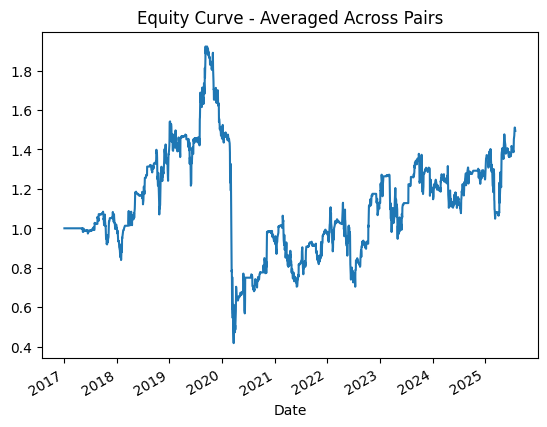

In [ ]:
combined_returns = pd.concat([r['strategy_returns'] for r in pair_results], axis=1).mean(axis=1)
equity_curve = (1 + combined_returns).cumprod()

equity_curve.plot(title="Equity Curve - Averaged Across Pairs")
